# 載入所需套件

In [1]:
import os,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# 爬蟲
### key = 搜尋關鍵字
### 注意! 本爬蟲為關閉SSL驗證拜訪網站，如怕不安全請勿使用，SSL版本待更新

In [ ]:
rs = requests.session()
key = '民法第1052條'
def get_hrefs_from_page(url,y,rs=rs):
    html = rs.get(url)
    soup = BeautifulSoup(html.text,'lxml')
    jud = soup.select('div td .hlTitle_scroll')
    for j in jud:
        jud_url = 'https://law.judicial.gov.tw/FJUD/' + j['href']
        write_data(jud_url,j.text,y)
    try:
        next_page_url = soup.select_one('div span #hlNext')['href'] 
        next_page_url = 'https://law.judicial.gov.tw' + next_page_url
        get_hrefs_from_page(next_page_url,y)
    except:
        print('end of track')
    
def write_data(url,title,y,rs=rs):
    
    html = rs.get(url)
    soup = BeautifulSoup(html.text,'lxml')
    jud_data = soup.select('div #jud')[0].text
    with open('C:/Users/HARRY/Desktop/judfiles1052/judfileten-1-10/jud{}/{}.txt'.format(y,title),'w',encoding='utf-8') as w:
        try:
            w.write(jud_data)
        except:
            w.write(jud_data.encode('utf8').decode('cp950','ignore'))

        
def Scrapy_jud_by_time(y,m1,m2,rs = rs):
    print(y,m1,m2)
    payload = {'__VIEWSTATE': 'N3fFhsqgHd0Sc2gaoTlLsrSJ9aEEKoysVptxdtr8zLKjvp2M/jCR5RCSmpXJ89MPjF7+mjJDsmX5J22XVPNO5RwJViAqekSnf6oMKQgeqJq5gLef8MC1eMkXZD/cdNVq9Kofz9QK43fWbOiipmm0jC/22repThRVTAhQrLhvBDThSUUfigaGFXqhp6djdofd4Kxm+ktpqFUdQFDI',
               '__VIEWSTATEGENERATOR': 'CCE6FCB1',
               '__VIEWSTATEENCRYPTED':'' ,
               '__EVENTVALIDATION': '9dHMXs6PjqxeOaVFORh+4Z83tyIDGL4XtlQaIAiMe5T+IsyUgx+7aaud7cwEk7u76dHZ8Qf7pqw65xuhwBWloEoN24c=',
               'jud_court': 'TPD,SLD,PCD,ILD,KLD,TYD,SCD,MLD,TCD,CHD,NTD,ULD,CYD,TND,KSD,CTD,HLD,TTD,PTD,PHD,KMD,LCD',
               'jud_sys': 'V',
            'jud_year': '',
            'sel_judword':'', 
            'jud_case':'', 
            'jud_no':'' ,
            'jud_no_end':'', 
            'dy1': '{}'.format(y),
            'dm1': '{}'.format(m1),
            'dd1': '01',
            'dy2': '{}'.format(y),
            'dm2': '{}'.format(m2),
            'dd2': '31',
            'jud_title':'' ,
            'jud_jmain': '',
            'jud_kw': key,
            'judtype': 'JUDBOOK',
            'whosub': '0',
            'ctl00$cp_content$btnQry': '送出查詢'}

    html = rs.post("https://law.judicial.gov.tw/FJUD/default_accfree.aspx",data = payload,verify = False)
    soup = BeautifulSoup(html.text,'lxml')
    connect = soup.select(".main-section > iframe")[0]['src']
    url = 'https://law.judicial.gov.tw/FJUD/' + str(connect)
    get_hrefs_from_page(url,y)
    
if __name__ == "__main__":
    rs = requests.session()
    y_list = list();m_list = list();
    y_list = ['108','107','106','105','104','103','102','101','100']
    m_list = ['01','02','03','04','05','06','07','08','09','10','11','12']
    for y in y_list:
        if y == '108':
            for m in range(0,5,2):  
                Scrapy_jud_by_time(y,m_list[m],m_list[m+1])  
        else:
            for m in range(0,11,2):  
                Scrapy_jud_by_time(y,m_list[m],m_list[m+1])

# 刪除非離婚訴訟的官司
### deletdata參數為判決書中間字詞，例如:臺灣屏東地方法院 101 年度 婚 字第 96 號民事判決 的婚字

In [ ]:
def deletdata(word):
    data = pd.read_csv('C:/Users/HARRY/Desktop/judten.csv')
    df = pd.DataFrame(data)
    for case in range(len(df)):
        if word in df['jud'][case]:
            df = df.drop(index = case)
    df.to_csv('C:/Users/HARRY/Desktop/judten.csv',encoding='utf_8_sig',index=False)
    return df

# 創建csv檔

In [ ]:
'''
一、民法第1052條第1項
    A:一、重婚。
    B:二、與配偶以外之人合意性交。
    C:三、夫妻之一方對他方為不堪同居之虐待。
    D:四、夫妻之一方對他方之直系親屬為虐待，或夫妻一方之直系親屬對他方
        為虐待，致不堪為共同生活。
    E:五、夫妻之一方以惡意遺棄他方在繼續狀態中。
    F:六、夫妻之一方意圖殺害他方。
    G:七、有不治之惡疾。
    H:八、有重大不治之精神病。
    I:九、生死不明已逾三年。
    J:十、因故意犯罪，經判處有期徒刑逾六個月確定。

二、民法第1052條第2項
    A:同居不履行、分居
    B:教養觀念差異過大
    C:感情破裂
    D:金錢觀差距
    E:不事生產
    F:賭博
    G:行方不明
'''
column = ['A','B','C','D','E','F','G']

jud_name = list()
dirs = os.listdir(path of judfileten)
for d in dirs:
    files = os.listdir(path of judfileten+'{}'.format(d))
    for file in files:
        jud_name.append(file.replace('.txt',''))

        
        
df = pd.DataFrame()
df['jud'] = jud_name
df['1052-1-1'] = 0
df['1052-1-2'] = 0
df['1052-1-3'] = 0
df['1052-1-4'] = 0
df['1052-1-5'] = 0
df['1052-1-6'] = 0
df['1052-1-7'] = 0
df['1052-1-8'] = 0
df['1052-1-9'] = 0
df['1052-1-10'] = 0
df['1052-2-A'] = 0
df['1052-2-B'] = 0
df['1052-2-C'] = 0
df['1052-2-D'] = 0
df['1052-2-E'] = 0
df['1052-2-F'] = 0
df['1052-2-G'] = 0
#df.to_csv(path of csv,encoding='utf_8_sig',index=False) #初始的dataframe寫入csv

# 將判決有包含1052-1、1052-2以及1052-1-1~1052-1-10的各自column改成1
### 注意! 1052-1 與 1052-1-1的差別，前者為民法第1052條第1項，後者為民法第1052條第1項第1款

In [ ]:
data = pd.read_csv(path of csv)
df = pd.DataFrame(data)
dirs = os.listdir(path of that directory)
for d in dirs:
    files = os.listdir(path of that directory+'{}'.format(d))
    for file in files:
        rowid = df[df['jud'] == file.replace('.txt','')].index
        print(d,file)
        df[column name][rowid] = 1
df.head()

# 將判決有包含1052-2且根據我們定義的原因column改成1
### reason為原因 可參照上方A~G

In [ ]:
reason = '行方不明'
bit = 'G'
def create_1052_2(word,col):
    for i in range(len(df)):
        if df['1052-2'][i] == 1:
            with open(path of judfileten+'{}/{}.txt'.format(df['judfile'][i],df['jud'][i]),'r',encoding='utf-8') as r:
                for text in r:
                    if word in text.strip():
                        df['1052-2-{}'.format(col)][i] = 1
                        break
create_1052_2(reason,bit)
df.head()

# 判別是勝訴或敗訴

In [ ]:
index_list = problem1.index
for i in index_list:
#     print(i,df['jud'][i])
    flagw = 0
    flagl = 0
    with open('C:/Users/HARRY/Desktop/judfileten/{}/{}.txt'.format(df['judfile'][i],df['jud'][i]),'r',encoding='utf-8') as r:
        df['win'][i] = 0

        for text in r:
            if flag>0:
#                 print(text.strip())
                if '准原告與被告離婚' in text.strip():
                    print(i)
                    df['win'][i] = 1
                flag =  flag - 1
            if re.search(r'主.*文',text.strip()):
                flagw = 5

        df['loss'][i] = 0
        for text2 in r:
            
            if flag>0:
#                 print(text2.strip())
                if '駁回' in text2.strip():
                    print(i)
                    df['loss'][i] = 1
                flag =  flag - 1
            if re.search(r'主.*文',text2.strip()):
                flagl = 5

# 資料分析

## 作圖區，由於csv以創建好，可以自行分析所需的部分，以下不一一解釋

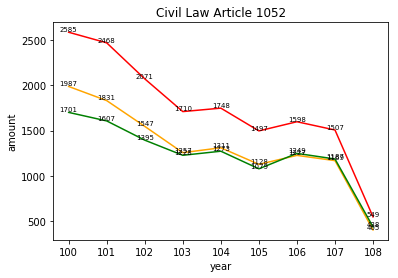

In [2]:
data = pd.read_csv('C:/Users/HARRY/Desktop/judten.csv')
df = pd.DataFrame(data)
y = list();y1 = list();y2 = list();
d_1052_1 = df['1052-1'] == 1
d_1052_2 = df['1052-2'] == 1
for year in range(100,109):
    jf = df['judfile'] == 'jud{}'.format(year)
    y.append(len(df[jf]))
    y1.append(len(df[jf&d_1052_1]))
    y2.append(len(df[jf&d_1052_2]))
y = np.array(y)
y1 = np.array(y1)
y2 = np.array(y2)
x = np.linspace(100,108,9)

plt.title('Civil Law Article 1052')
plt.xlabel('year')
plt.ylabel('amount')
plt.plot(x,y,'r')
plt.plot(x,y1,'orange')
plt.plot(x,y2,'g')
for a, b in zip(x, y):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)
for a, b in zip(x, y1):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)
for a, b in zip(x, y2):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=7)
plt.savefig('C:/Users/HARRY/Desktop/amount.png')
plt.show()

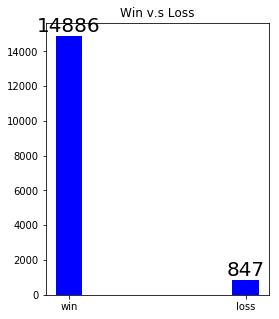

In [6]:
y_win = pd.value_counts(df['win'])
x = ['win','loss']
plt.figure(figsize=(4,5))
plt.title('Win v.s Loss')
plt.bar(x,[y_win[1],y_win[0]],width = 0.15,color='b')
for xt, yt in zip(x, [y_win[1],y_win[0]]):
    plt.text(xt, yt+10 , yt, ha='center', va='bottom',fontsize=20)
plt.savefig('C:/Users/HARRY/Desktop/win_loss.png')
plt.show()

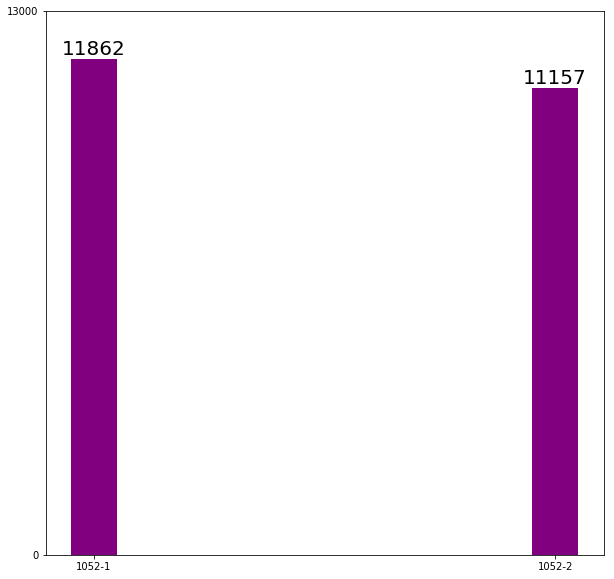

In [7]:
jud1052_1 = pd.value_counts(df['1052-1'])
jud1052_2 = pd.value_counts(df['1052-2'])
x_10521 = ['1052-1','1052-2']
plt.figure(figsize=(10,10))
plt.bar(x_10521,[jud1052_1[1],jud1052_2[1]],width = 0.1,color='purple')
for xt, yt in zip(x_10521, [jud1052_1[1],jud1052_2[1]]):
    plt.text(xt, yt , yt, ha='center', va='bottom',fontsize=20)
plt.yticks([0,13000])
plt.savefig('C:/Users/HARRY/Desktop/1052_1_2.png')
plt.show()

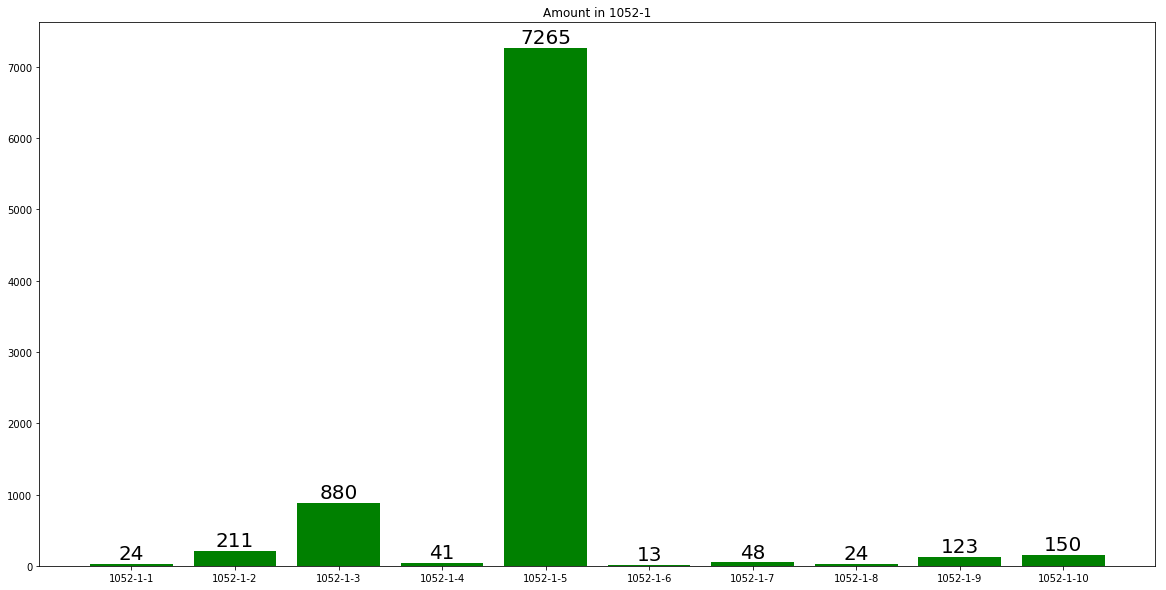

In [8]:
x = list()
y = list()
cols = df.columns[6:16]
x = cols
for c in cols:
    y.append(pd.value_counts(df[c])[1])
plt.figure(figsize=(20,10))
plt.title('Amount in 1052-1')
plt.bar(x,y,color = 'g')
for xt, yt in zip(x, y):
    plt.text(xt, yt+10 , yt, ha='center', va='bottom',fontsize=20)
plt.savefig('C:/Users/HARRY/Desktop/1052_1_amount.png')
plt.show()

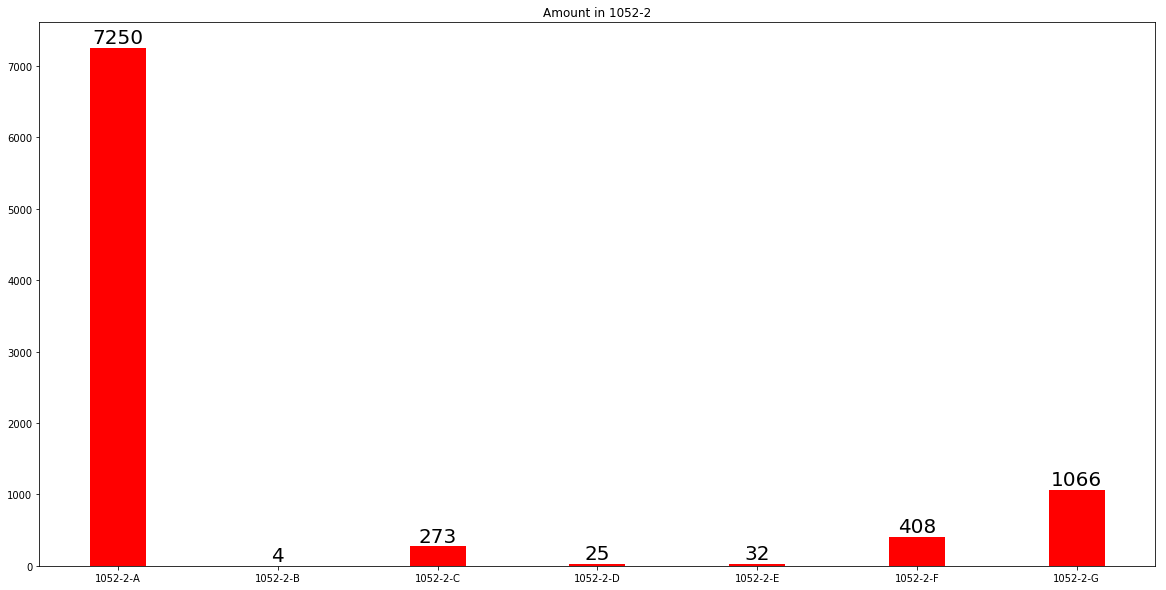

9058

In [9]:
import numpy as np
x = list()
y = list()
cols = df.columns[16::]
x = cols
for c in cols:
    y.append(pd.value_counts(df[c])[1])
plt.figure(figsize=(20,10))
plt.title('Amount in 1052-2')
plt.bar(x,y,color = 'r',width = 0.35)
for xt, yt in zip(x, y):
    plt.text(xt, yt+10 , yt, ha='center', va='bottom',fontsize=20)
plt.savefig('C:/Users/HARRY/Desktop/1052_2_amount.png')
plt.show()
sum(y)

In [10]:
from sklearn.linear_model import LinearRegression
x = [21914,21501,21516,20600,19492,19701,19988,20359]
y = []
cond1 = df['1052-1-5'] == 1
for year in range(100,108):
    cond2 = df['judfile'] == 'jud{}'.format(year)
    y.append(len(df[cond1&cond2]))
x = np.array(x)
y = np.array(y)
reg = LinearRegression()
reg.fit(x.reshape(-1,1),y)
reg.coef_[0],reg.intercept_

(0.2593893922750802, -4471.83329652997)

In [11]:
ols = sm.add_constant(x)
est = sm.OLS(y, ols)
info = est.fit()
print(info.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     16.72
Date:                Sun, 23 Jun 2019   Prob (F-statistic):            0.00643
Time:                        00:43:16   Log-Likelihood:                -50.457
No. Observations:                   8   AIC:                             104.9
Df Residuals:                       6   BIC:                             105.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4471.8333   1309.859     -3.414      0.0

c:\users\harry\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


## 最後補上一些可用的function，如果照以上步驟一步一步下來不會完全得到與我們一模一樣的結果，因為過程中有去刪剪一些無法控制的判決書(字詞定義不對、語句錯誤等等)，會稍有不同

### 自訂mask條件去過濾有問題的data

In [ ]:
mask1 = df['win'] == 1
mask2 = df['win'] == 0
problem = df[(mask1 & mask2)]
problem
removeid = problem.index
removeid = list(removeid)
data = pd.read_csv(path of csv)
df = pd.DataFrame(data)
df = df.drop(index=removeid)
df.to_csv(path of csv,encoding='utf_8_sig',index=False) 

# 有疑問請mail : harry860109@gmail.com